In [ ]:
# 1. Setup and Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, GRU, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

# Check for GPU
print("TensorFlow Version:", tf.__version__)
if tf.config.list_physical_devices('GPU'):
    print("✅ GPU is available. Training will be fast.")
else:
    print("⚠️ GPU not detected. Go to Runtime > Change runtime type > T4 GPU to speed up training.")

TensorFlow Version: 2.19.0
✅ GPU is available. Training will be fast.


In [ ]:
# 2. Load and Inspect Data
# We use the cleaned CSV directly to avoid the mistake of uncleaned test Dataset.

csv_path = 'balanced_preprocessed_data.csv'

try:
    df = pd.read_csv(csv_path)
    print(f"Successfully loaded Dataset. Shape: {df.shape}")
except FileNotFoundError:
    print("❌ Error: CSV file not found. Please upload 'balanced_preprocessed_data.csv' to the Colab files area.")

# Drop any accidental nulls created during CSV saving/loading
df.dropna(inplace=True)

# Ensure 'type' is integer (0 or 1)
# The snippet showed 'type' as 0/1, but sometimes CSVs read them as strings.
df['type'] = pd.to_numeric(df['type'], errors='coerce')
df.dropna(subset=['type'], inplace=True)

# Preview
print("\nData Preview:")
print(df.head())

# Check class balance
print("\nClass Distribution:")
print(df['type'].value_counts())

Successfully loaded data. Shape: (50000, 2)

Data Preview:
                                         description  type
0  secret kells exist film ive waiting year seein...     1
1  understand fan filmmaker roman polanski could ...     1
2  bela lugosi typecast fantastic twelvepart adve...     0
3  thought seen movie twice fact read review didn...     0
4  disappointing musical version margaret landons...     0

Class Distribution:
type
1    25000
0    25000
Name: count, dtype: int64


In [ ]:
# 3. Data Preparation

# Parameters
MAX_VOCAB_SIZE = 20000  # Maximum number of unique words to keep
MAX_SEQUENCE_LENGTH = 200 # Max length of a review (truncate if longer, pad if shorter)
EMBEDDING_DIM = 128     # Vector size for each word

# Split into X (text) and y (labels)
# Note: The CSV provided seems to have column 'description' for text and 'type' for label
X = df['description'].astype(str).values
y = df['type'].values

# Tokenization
print("Tokenizing text...")
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(X)

# Padding
print("Padding sequences...")
X_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Splitting Data
# We perform the split HERE to ensure Train and Test are from the same processed source.
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Tokenizing text...
Found 109898 unique tokens.
Padding sequences...
Training set shape: (40000, 200)
Testing set shape: (10000, 200)


In [ ]:
# 4. Build the BiGRU Model

model = Sequential()

# Embedding Layer
model.add(Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))

# Spatial Dropout (Drops entire 1D feature maps instead of individual elements)
model.add(SpatialDropout1D(0.2))

# Bidirectional GRU Layer
# Return_sequences=False because we only need the final state for classification
model.add(Bidirectional(GRU(64, dropout=0.2, recurrent_dropout=0)))

# Dense Layers
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid')) # Sigmoid for binary classification (0 or 1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 5. Train the Model

# Callbacks for optimization
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_bigru_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

BATCH_SIZE = 64
EPOCHS = 10  # It will likely stop earlier due to EarlyStopping

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7369 - loss: 0.4913
Epoch 1: val_accuracy improved from -inf to 0.91130, saving model to best_bigru_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.7371 - loss: 0.4911 - val_accuracy: 0.9113 - val_loss: 0.2384
Epoch 2/10
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9489 - loss: 0.1539
Epoch 2: val_accuracy improved from 0.91130 to 0.94200, saving model to best_bigru_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.9489 - loss: 0.1539 - val_accuracy: 0.9420 - val_loss: 0.1663
Epoch 3/10
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9727 - loss: 0.0853
Epoch 3: val_accuracy improved from 0.94200 to 0.95180, saving model to best_bigru_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.9727 - loss: 0.0853 - val_accuracy: 0.9518 - val_loss: 0.1636
Epoch 4/10
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9866 - loss: 0.0462
Epoch 4: val_

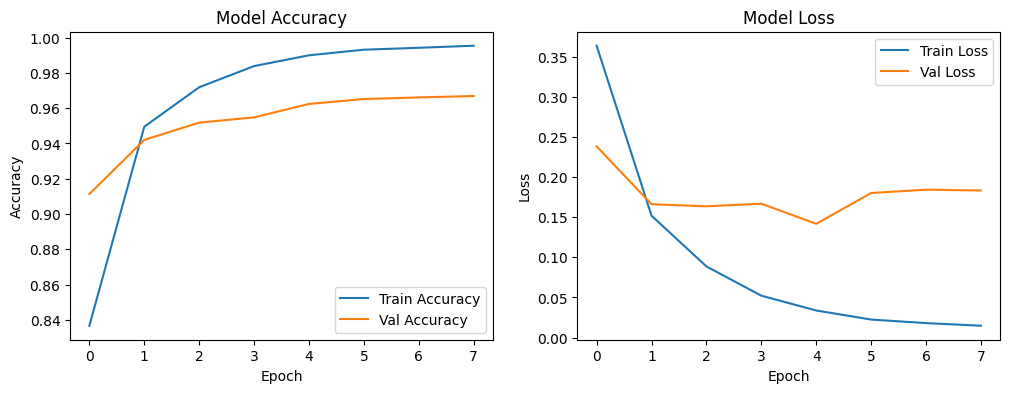


Final Test Accuracy: 96.24%
Final Test Loss: 0.1418


In [ ]:
# 6. Evaluate and Visualize Results

# Plot accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Final Evaluation on Test Set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal Test Accuracy: {accuracy*100:.2f}%")
print(f"Final Test Loss: {loss:.4f}")

In [ ]:
# 7. Test on Custom Examples (Optional)

def predict_sentiment(text):
    # Preprocess the input text similarly (basic cleaning + tokenization)

    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    prediction = model.predict(padded)[0][0]

    sentiment = "Positive" if prediction > 0.5 else "Negative"
    print(f"Text: '{text}'")
    print(f"Sentiment: {sentiment} ({prediction:.4f})")
    print("-" * 30)

# Test examples
predict_sentiment("This movie was absolutely fantastic! The acting was great.")
predict_sentiment("I hated this film. It was a complete waste of time and boring.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
Text: 'This movie was absolutely fantastic! The acting was great.'
Sentiment: Positive (0.9832)
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Text: 'I hated this film. It was a complete waste of time and boring.'
Sentiment: Negative (0.0002)
------------------------------
